In [7]:
import os
import random
import numpy as np
from functools import partial
import pickle
from glob import glob
from tqdm.notebook import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt
import yaml
import torch
from ml_collections import ConfigDict
from scipy.stats.stats import pearsonr
import cv2
from utils import *

import warnings
warnings.filterwarnings("ignore")


device = torch.device('cuda:0')

torch.cuda.is_available()

True

In [8]:
model_name = 'eegadanet'
model_path = 'ckpts/'+model_name

if not os.path.isdir(model_path):
    os.mkdir(model_path)

In [9]:
with open(model_path+'/config.yaml') as f:
    config = ConfigDict(yaml.load(f, Loader=yaml.FullLoader))

config

data:
  chunk_size: 512
  delta_snr:
  - -5
  - 5
  noise_scale: 5
  noise_type: EOG
  sample_rate: 200
model:
  activation: gelu
  att_dim: 128
  att_drop: 0.1
  att_heads: 8
  emb_freqs: 4
  kernel_size: 3
  norm: BatchNorm
  num_blocks:
  - 1
  - 1
  - 1
  - 2
  - 2
  - 4
  num_channels: 16
  scale: 2
training:
  batch_size: 32
  cv_seed: 0
  cv_splits: 3
  early_stop:
    patience: 100
    tolerance: 0.0001
  lr: 0.0002

# Dataset

In [10]:
eegs = pickle.load(open('data/klados/EEG.pickle', 'rb'))

eogs = pickle.load(open('data/klados/EOG.pickle', 'rb'))
eogs = [eog*config.data.noise_scale for eog in eogs]

sr = config.data.sample_rate


class Dataset(torch.utils.data.Dataset):
    def __init__(self, X):        
        self.X = X
               
    def __len__(self):
        return len(self.X)
            
    def __getitem__(self, index):
        trial_id = self.X[index]
        x, n = eegs[trial_id], eogs[trial_id]
        return x+n, x

In [11]:
from eeg_positions import get_elec_coords

_df = get_elec_coords(system='1020', dim='3d')

coord_dict = {}
for i, (c,x,y,z) in enumerate(_df.values):
    if c=='T7':
        coord_dict['T3'] = (x,y,z)
    elif c=='T8':
        coord_dict['T4'] = (x,y,z)
    elif c=='P7':
        coord_dict['T5'] = (x,y,z)
    elif c=='P8':
        coord_dict['T6'] = (x,y,z)
    coord_dict[c] = (x,y,z)


# order of electrodes in Klados dataset
electrodes_klados = [
    'Fp1', 'Fp2', 'F3', 'F4', 
    'C3', 'C4', 'P3', 'P4', 
    'O1', 'O2', 'F7', 'F8', 
    'T3', 'T4', 'T5', 'T6', 
    'Fz', 'Cz', 'Pz'
]
coords_klados = torch.FloatTensor([coord_dict[e] for e in electrodes_klados])


# electrodes commonly used for sleep monitoring
electrodes_sleep = ['F3','F4','C3','C4','O1','O2']
coords_sleep = torch.FloatTensor([coord_dict[e] for e in electrodes_sleep])

# Model complexity

### Memory Usage

In [12]:
C = 19
dummy_chunk = torch.zeros([C,config.data.chunk_size]).to(device)
dummy_coords = torch.zeros([C,3]).to(device)

model = UNet(config.model).eval().to(device)
model(dummy_chunk[None], coords=dummy_coords)

torch.cuda.memory_allocated() / 2**20

11.5771484375

### FLOPS

  0%|          | 0/60 [00:00<?, ?it/s]

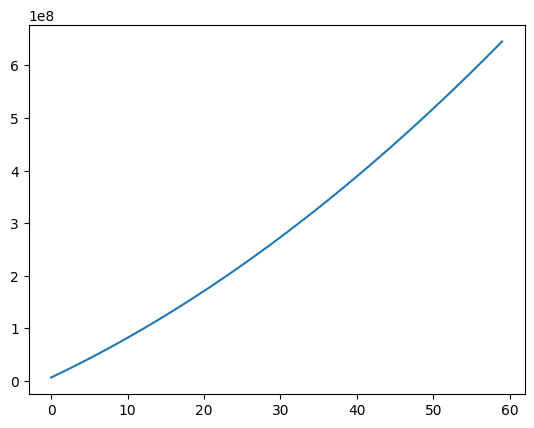

In [13]:

C = 60
dummy_chunk = torch.zeros([C,config.data.chunk_size]).to(device)
dummy_coords = torch.zeros([C,3]).to(device)

model = UNet(config.model).eval().to(device)

flops = []
for num_channels in tqdm(range(1,C+1)):

    y, c = dummy_chunk[:num_channels], dummy_coords[:num_channels]

    n = get_flops(partial(model,coords=c), y[None]) 

    flops.append(n)

plt.plot(flops)

# Evaluation

### Load model

In [22]:
from eegadanet import UNet
from sklearn.model_selection import KFold


def denoise(model, y, coords):
    return chunk_and_apply(
        partial(model, coords=coords, save_matrix=True),
        y.to(device), 
        batch_size=config.training.batch_size, 
        chunk_size=config.data.chunk_size
    )
    

epoch = 307
ckpts = torch.load(model_path+f'/epoch{epoch}.ckpt', map_location=device)

cv = KFold(n_splits=config.training.cv_splits, shuffle=True, random_state=config.training.cv_seed)

folds = []
for (trainX, valX), ckpt in zip(cv.split(eegs), ckpts):
    model = UNet(config.model).eval().to(device)
    model.load_state_dict(ckpt)

    folds.append({ 
        'model': model,
        'valset': Dataset(valX)
    })

### Charts

In [25]:
folds[0]['valset'].X

array([ 2,  4,  7, 10, 11, 22, 26, 28, 30, 31, 32, 33, 37, 38, 42, 45, 48,
       53])

In [26]:
fold = folds[0] 

y, x = fold['valset'][0]

x_ = denoise(fold['model'], y.to(device), coords_klados) 

y.shape, x_.shape

(torch.Size([19, 5801]), torch.Size([19, 5801]))

Using matplotlib as 2D backend.


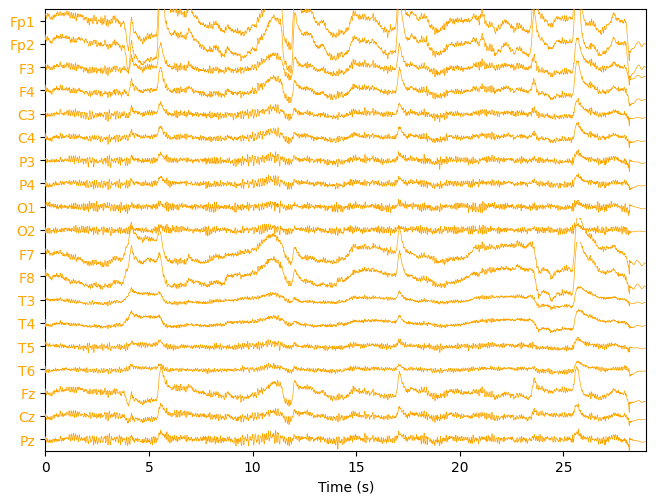

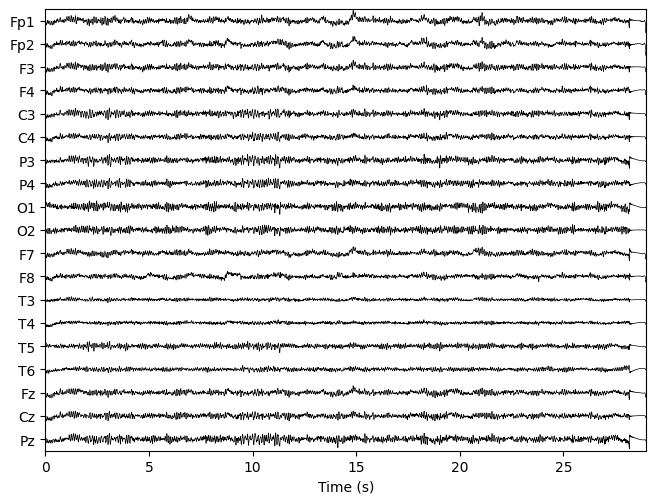

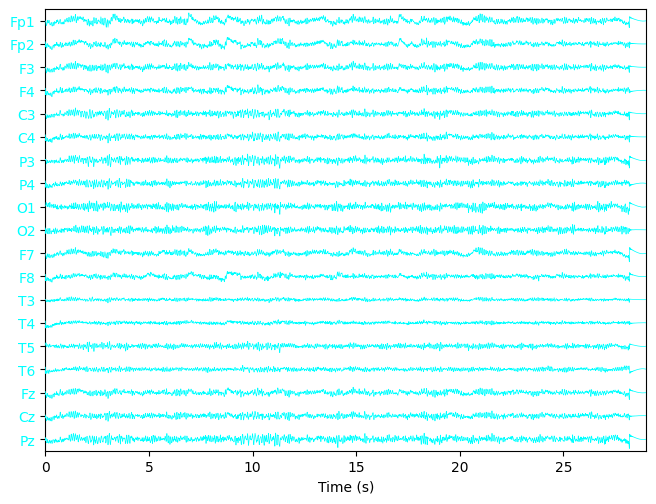

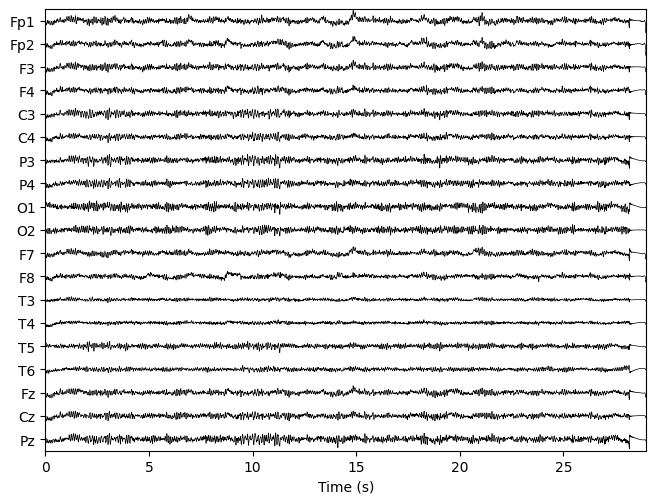

In [27]:
raw_y = tensor2raw(y, sr, electrodes_klados, scale=0.2)
raw_x = tensor2raw(x, sr, electrodes_klados, scale=0.2)
raw_x_ = tensor2raw(x_, sr, electrodes_klados, scale=0.2)

plot_overlayed_chart(raw_y, raw_x_, model_path+'/figures/chart_xy.png', size=[7,5], color='orange')
plot_overlayed_chart(raw_x, raw_x_, model_path+'/figures/chart_xx.png', size=[7,5], color='cyan')

### Evaluate on specific electrode placement

In [23]:
# specify combination of channels
electrodes, coords = electrodes_klados, coords_klados
#electrodes, coords = electrodes_sleep, coords_sleep

electrode_indices = [electrodes_klados.index(e) for e in electrodes]

In [24]:
X_, X = [], []
rawX_, rawX = [], []

for fold in folds:
    
    for y, x in tqdm(fold['valset']):

        y, x = [eeg[electrode_indices] for eeg in [y,x]]

        with torch.no_grad():
            x_ = denoise(fold['model'], y.to(device), coords) 
            
        X_.append(x_), rawX_.append(tensor2raw(x_, sr, electrodes))
        X.append(x), rawX.append(tensor2raw(x, sr, electrodes))

len(X_), len(X)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

(54, 54)

In [25]:
# metrics per channel
rrmse, srrmse, cc = [], [], []
for i, e in enumerate(electrodes):
    rrmse.append(np.mean([RRMSE(x_[i] ,x[i]) for x_, x in zip(X_, X)]))
    srrmse.append(np.mean([RRMSE(PSD(x_, e), PSD(x, e)) for x_, x in zip(rawX_, rawX)]))
    cc.append(np.mean([pearsonr(x_[i], x[i])[0] for x_, x in zip(X_, X)]))

np.mean(rrmse), np.mean(srrmse), np.mean(cc)

(0.2891901, 0.31996473790548224, 0.9380572816091357)

In [26]:
# electrodes sorted in increasing order of SNR (in Klados dataset)
electrodes_snr_sorted = pickle.load(open('data/klados/electrodes_snr_sorted', 'rb'))
electrodes_snr_sorted = [e for e in electrodes_snr_sorted if e in electrodes]

scores = {e:[r,s,c] for e,r,s,c in zip(electrodes,rrmse,srrmse,cc)}
sorted_scores = [scores[e] for e in electrodes_snr_sorted]

sorted_scores

[[0.635119, 0.4872800067462861, 0.7721951777047713],
 [0.6552617, 0.5160181437847291, 0.7538934701663828],
 [0.50311935, 0.4225091716757239, 0.8580559823243509],
 [0.46596453, 0.39444328096722825, 0.8823216241019695],
 [0.34230724, 0.36864623294914195, 0.9355009150746473],
 [0.36700135, 0.3885358540918723, 0.9267077097938511],
 [0.36061293, 0.35764317584870775, 0.9289582660838157],
 [0.30711806, 0.32535958700029105, 0.9490989531588071],
 [0.27527568, 0.2842756417361983, 0.9596755814365296],
 [0.21931088, 0.26533344239277284, 0.9728737212506218],
 [0.19176771, 0.29854558477656734, 0.9798664261167759],
 [0.20956822, 0.29822445593641916, 0.9762621716737072],
 [0.15620327, 0.22071887623859873, 0.9871326466462124],
 [0.1750754, 0.260822290063084, 0.9838183598174396],
 [0.13413526, 0.2266731742509491, 0.9902839493885854],
 [0.1372709, 0.26616820182943496, 0.9898858911086269],
 [0.1339966, 0.2515082366476218, 0.9900160445339027],
 [0.114711635, 0.24373534673276115, 0.9930570238193795],
 [0.11

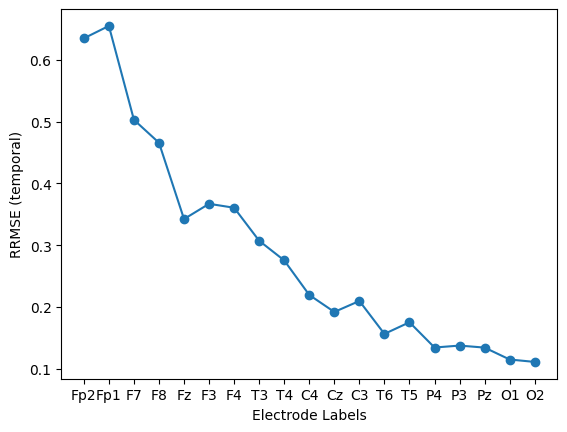

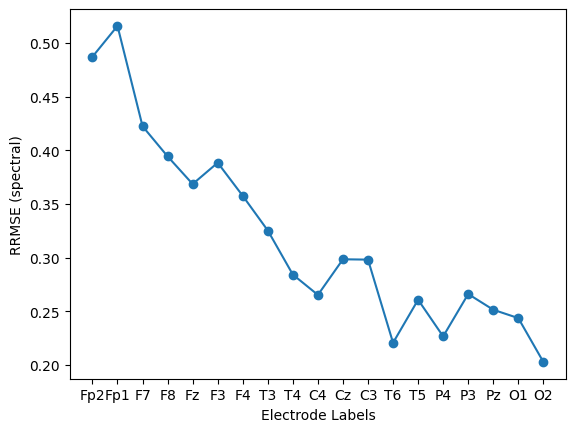

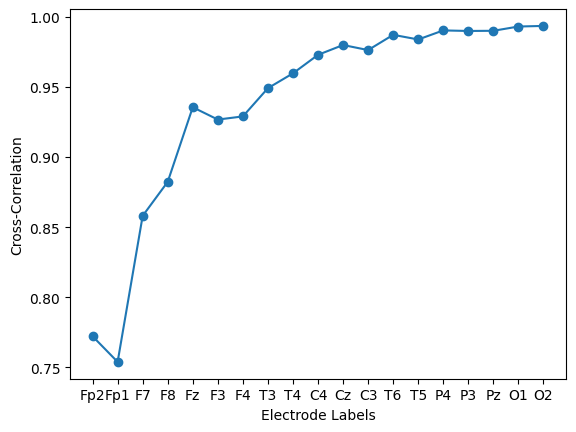

In [27]:
# Line chart
fig, ax = plt.subplots()
ax.plot(electrodes_snr_sorted, [r for r,s,c in sorted_scores], marker = "o")
ax.set_xlabel("Electrode Labels")
ax.set_ylabel("RRMSE (temporal)")

fig, ax = plt.subplots()
ax.plot(electrodes_snr_sorted, [s for r,s,c in sorted_scores], marker = "o")
ax.set_xlabel("Electrode Labels")
ax.set_ylabel("RRMSE (spectral)")

fig, ax = plt.subplots()
ax.plot(electrodes_snr_sorted, [c for r,s,c in sorted_scores], marker = "o")
ax.set_xlabel("Electrode Labels")
ax.set_ylabel("Cross-Correlation")

plt.show()

In [39]:
pickle.dump([r for r,s,c in sorted_scores], open(model_path+f'/rrmse', 'wb'))
pickle.dump([s for r,s,c in sorted_scores], open(model_path+f'/srrmse', 'wb'))
pickle.dump([c for r,s,c in sorted_scores], open(model_path+f'/cc', 'wb'))

### Evaluate by number of channels

In [28]:
from itertools import combinations

n_list = [1,4,7,10,13,16,19]
max_num_placements = 10

rrmse_per_n, srrmse_per_n, cc_per_n = [], [], []

for n in n_list:

    rrmse, srrmse, cc = [], [], []
    for target_e in tqdm(electrodes_klados):
        target_i = electrodes_klados.index(target_e)

        other_e = set(range(19))-set([target_i])
        placements = list(combinations(other_e, n-1))
        N = min(max_num_placements, len(placements))

        _rrmse, _srrmse, _cc = [], [], []
        for E in random.sample(placements, N):

            electrode_indices = [target_i] + list(E)
            electrodes = [electrodes_klados[i] for i in electrode_indices]
    
            X_, X = [], []
            rawX_, rawX = [], []
            for fold in folds:

                for y, x in fold['valset']:

                    y, x = y[electrode_indices], x[electrode_indices]
                    
                    coords = coords_klados[electrode_indices]
            
                    with torch.no_grad():
                        x_ = denoise(fold['model'], y.to(device), coords) 

                    X_.append(x_), rawX_.append(tensor2raw(x_, sr, electrodes))
                    X.append(x), rawX.append(tensor2raw(x, sr, electrodes))

            i = electrode_indices.index(target_i)
            _rrmse.append(np.mean([RRMSE(x_[i], x[i]) for x_, x in zip(X_, X)]))
            _srrmse.append(np.mean([RRMSE(PSD(x_, target_e), PSD(x, target_e)) for x_, x in zip(rawX_, rawX)]))
            _cc.append(np.mean([pearsonr(x_[i], x[i])[0] for x_, x in zip(X_, X)]))

        rrmse.append(np.mean(_rrmse)), srrmse.append(np.mean(_srrmse)), cc.append(np.mean(_cc))
    
    rrmse_per_n.append(rrmse), srrmse_per_n.append(srrmse), cc_per_n.append(cc)


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

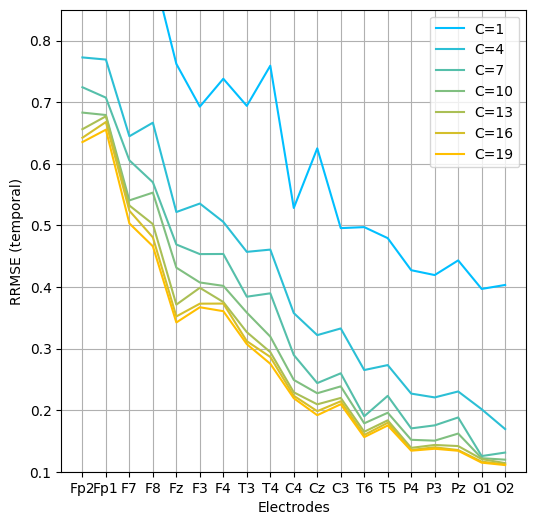

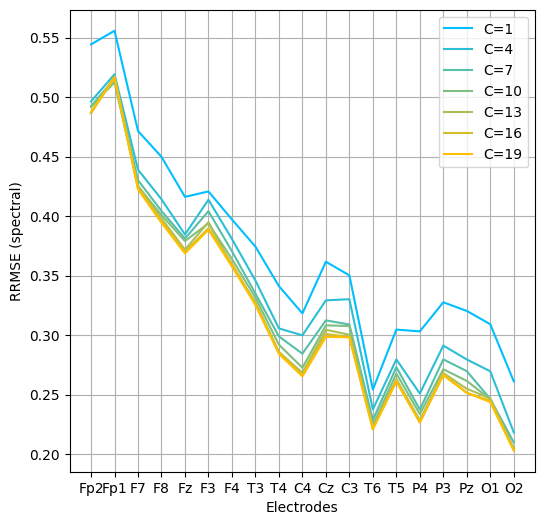

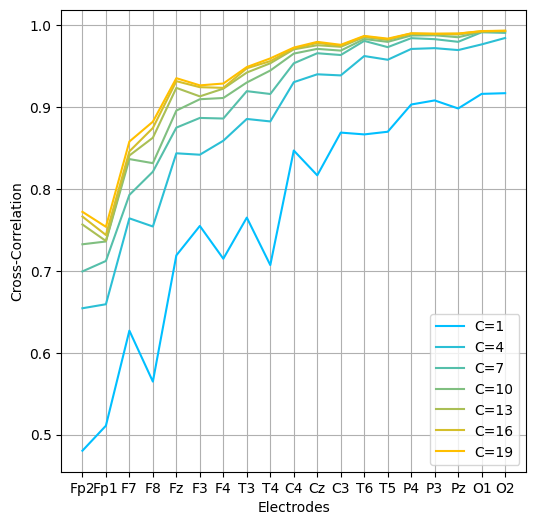

In [32]:
import matplotlib as mpl

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[str((i,0.75,1-i)) for i in np.linspace(0,1,num=7)]) 

x_axis = pickle.load(open('data/klados/electrodes_snr_sorted', 'rb'))
sort_by_snr = [electrodes_klados.index(e) for e in x_axis]

fig, ax = plt.subplots(figsize=(6, 6))
for i, n in enumerate(n_list):
    rrmse = rrmse_per_n[i]
    ax.plot(x_axis, np.array(rrmse)[sort_by_snr], marker="", label=f'C={n}')

ax.set_xlabel("Electrodes")
ax.set_ylabel("RRMSE (temporal)")
ax.legend()
plt.grid()
plt.ylim(0.1, 0.85)
plt.show()


fig, ax = plt.subplots(figsize=(6, 6))
for i, n in enumerate(n_list):
    srrmse = srrmse_per_n[i]
    ax.plot(x_axis, np.array(srrmse)[sort_by_snr], marker="", label=f'C={n}')

ax.set_xlabel("Electrodes")
ax.set_ylabel("RRMSE (spectral)")
ax.legend()
plt.grid()
#plt.ylim(0.1, 0.85)
plt.show()


fig, ax = plt.subplots(figsize=(6, 6))
for i, n in enumerate(n_list):
    cc = cc_per_n[i]
    ax.plot(x_axis, np.array(cc)[sort_by_snr], marker="", label=f'C={n}')

ax.set_xlabel("Electrodes")
ax.set_ylabel("Cross-Correlation")
ax.legend()
plt.grid()
#plt.ylim(0.1, 0.85)
plt.show()

# Visualize attention matrix

In [28]:
# channels and model used for last inference
electrodes = electrodes_klados
model = folds[0]['model']

# collect all attention matrices
M = torch.stack([
    att.matrix for att in 
    [block.att for block in model.down_blocks] + [model.bottleneck_block.att] + [block.att for block in model.up_blocks]
], 1)

M = M.mean(0)  # mean over segments

M.shape  # [layers, heads, C, C]

torch.Size([11, 8, 19, 19])

In [29]:
from eeg_positions import get_elec_coords

_df = get_elec_coords(system='1020')

coord_dict_2d = {}
for i, (c,x,y) in enumerate(_df.values):
    if c=='T7':
        coord_dict_2d['T3'] = (x,y)
    elif c=='T8':
        coord_dict_2d['T4'] = (x,y)
    elif c=='P7':
        coord_dict_2d['T5'] = (x,y)
    elif c=='P8':
        coord_dict_2d['T6'] = (x,y)
    coord_dict_2d[c] = (x,y)

### per head

F3 (Layer 2)


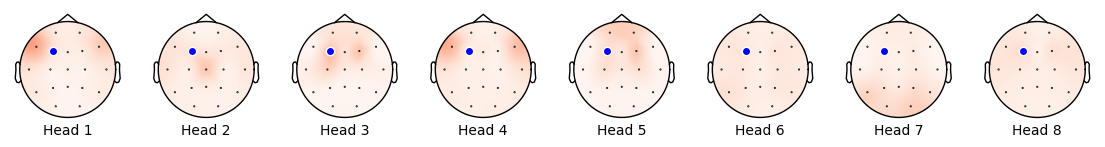

In [30]:
import mne

# specify query channel and layer
E = 'F3'
L = 2


W = M[L][:,electrodes.index(E)]

print(E, f'(Layer {L})')

fig, axes = plt.subplots(1, len(W), figsize=(14, 3))
for i, ax in enumerate(axes):
    ax.set_xlabel(f'Head {i+1}')
    mne.viz.plot_topomap(
        W[i].cpu(), 
        np.array([coord_dict_2d[e] for e in electrodes]), 
        mask=np.array([e==E for e in electrodes]), 
        mask_params=dict(markerfacecolor='b', markeredgecolor='w', linewidth=0, markersize=6), 
        contours=0, 
        sphere=(0,0,0,0.9), 
        res=16, size=1, 
        cmap='Reds', vlim=(0.0,0.8),
        show=False, axes=ax
    )

plt.show()

### average over heads

Fp1


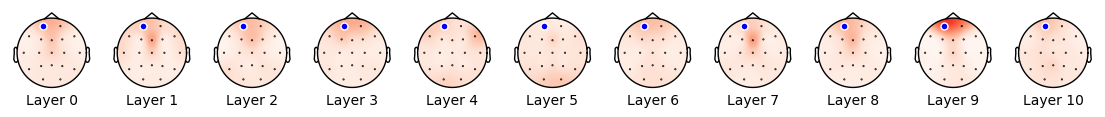

In [31]:
import mne

# specify query channel
E = 'Fp1'

print(E)
fig, axes = plt.subplots(1, len(M), figsize=(14, 3))
for i, ax in enumerate(axes):
    w = M[i][:,electrodes.index(E)].mean(0)
    ax.set_xlabel(f'Layer {i}')
    mne.viz.plot_topomap(
        w.cpu(), 
        np.array([coord_dict_2d[e] for e in electrodes]), 
        mask=np.array([e==E for e in electrodes]), 
        mask_params=dict(markerfacecolor='b', markeredgecolor='w', linewidth=0, markersize=5), 
        contours=0, 
        sphere=(0,0,0,0.9), 
        res=16, size=1, 
        cmap='Reds', vlim=(0.0,0.5),
        show=False, axes=ax
    )
    
plt.show()

### average over layers & heads

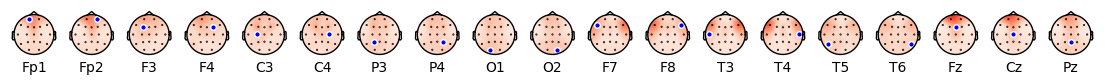

In [32]:
import mne

fig, axes = plt.subplots(1, len(electrodes), figsize=(14, 3))
for i, ax in enumerate(axes):
    E = electrodes[i]
    w = M[...,i,:].mean(dim=(0,1))
    ax.set_xlabel(E)
    mne.viz.plot_topomap(
        w.cpu(), 
        np.array([coord_dict_2d[e] for e in electrodes]), 
        mask=np.array([e==E for e in electrodes]), 
        mask_params=dict(markerfacecolor='b', markeredgecolor='w'), 
        contours=0, 
        sphere=(0,0,0,0.9), 
        res=16, size=1, 
        cmap='Reds', vlim=(0.0,0.3),
        show=False, axes=ax
    )
        
plt.show()